In [46]:
# ---------------------------------------------
# SECTION 1 — Setup, paths, and data loading
# ---------------------------------------------

# Imports: pandas for data work, numpy for numeric helpers, matplotlib for charts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile

DATA_PATH = './online_retail_II.csv.zip'
# Handle zipped dataset
if DATA_PATH.endswith(".zip"):
    with zipfile.ZipFile(DATA_PATH) as z:
        csv_name = z.namelist()[0]  # get the CSV inside the zip
        with z.open(csv_name) as f:
            df = pd.read_csv(f, encoding="utf-8", low_memory=False)
else:
    df = pd.read_csv(DATA_PATH, encoding="utf-8", low_memory=False)# Make output nicer in notebook
pd.set_option("display.max_columns", 50)

# Quick sanity check: rows and columns
print("Shape (rows, cols):", df.shape)

# Preview a few rows to understand the raw structure
df.head(5)

Shape (rows, cols): (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [47]:
# ---------------------------------------------
# SECTION 2 — Initial structure checks
# ---------------------------------------------

# Peek at schema: column names, non-null counts, and dtypes
df.info()

# Numeric summary to catch obvious issues (extreme values, zeros, negatives)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [48]:
# ---------------------------------------------------------------
# SECTION 3 — Basic hygiene: names, dates, and duplicate removal
# ---------------------------------------------------------------

# 3.1 Normalize column names to snake_case (easier to reference in code)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# 3.2 Parse likely date columns into true datetime if present
for cand in ["invoicedate", "invoice_date", "date"]:
    if cand in df.columns:
        df[cand] = pd.to_datetime(df[cand], errors="coerce")

# 3.3 Remove exact duplicate rows (prevents double-counting)
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Removed {before - after} duplicate rows")
df.head(3)


Removed 34335 duplicate rows


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


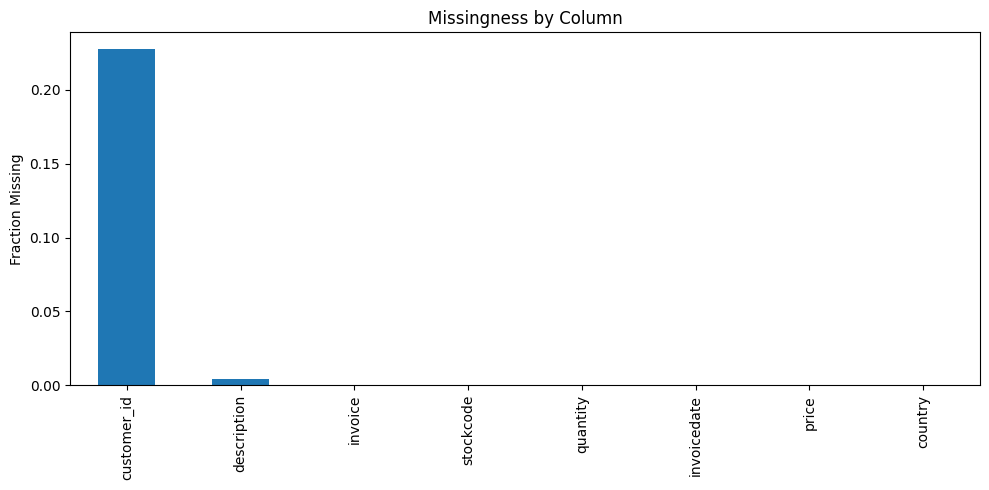

In [49]:
# ---------------------------------------------------
# SECTION 4 — Missingness profile and simple strategy
# ---------------------------------------------------

# Fraction missing by column (sorted)
missing = df.isna().mean().sort_values(ascending=False).to_frame("fraction_missing")
missing.head(12)

# Bar chart of missingness across all columns (matplotlib only; one chart per figure)
plt.figure(figsize=(10, 5))
missing["fraction_missing"].plot(kind="bar")
plt.ylabel("Fraction Missing")
plt.title("Missingness by Column")
plt.tight_layout()
plt.show()

# Light-touch example imputation:
# - CustomerID is often missing in Online Retail II; keep row but mark missingness explicitly using a filled category.
if "customerid" in df.columns:
    df["customerid"] = df["customerid"].astype("Int64")  # nullable integer dtype
    df["customerid_filled"] = df["customerid"].astype("string").fillna("Unknown")


In [50]:
# ----------------------------------------------------------
# SECTION 5 — Noisy values, business rules, and safe filters
# ----------------------------------------------------------

# In retail:
# - Negative quantity typically indicates returns/cancellations. Keep them but flag them.
# - Unit price should not be negative (likely a data error) — we remove those rows.

# 5.1 Returns/cancellations flag
if "quantity" in df.columns:
    df["is_return_or_cancel"] = df["quantity"] < 0
else:
    df["is_return_or_cancel"] = False  # fallback if quantity is missing

# 5.2 Remove negative unit prices (truly invalid)
if "unitprice" in df.columns:
    before = len(df)
    df = df[df["unitprice"].fillna(0) >= 0]
    print(f"Removed {before - len(df)} rows with negative unitprice")

# 5.3 Create a monetary line item total if quantity and unitprice exist
if {"quantity", "unitprice"}.issubset(df.columns):
    df["line_total"] = df["quantity"] * df["unitprice"]

df.head(3)


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,is_return_or_cancel
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False
